## Imports

In [1]:
# General imports 
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from tqdm import tqdm
import tempfile
import csv
import requests as r
from Bio import SeqIO
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


# Import structuremap functions
import structuremap.utils
structuremap.utils.set_logger()
from structuremap.processing import download_alphafold_cif, download_alphafold_pae, format_alphafold_data, annotate_accessibility, get_smooth_score, annotate_proteins_with_idr_pattern, get_extended_flexible_pattern, get_proximity_pvals, perform_enrichment_analysis, perform_enrichment_analysis_per_protein, evaluate_ptm_colocalization, extract_motifs_in_proteome
from structuremap.plotting import plot_enrichment, plot_ptm_colocalization

## Set Parameters of Analysis

In [2]:
analysis_threshold = 20 # number of amino acids either side to analyze

modifications = ["649.3660", "655.3735"] # which modifications we are looking for, as regex strings
heavy_modification = "655.3735" 
light_modification = "649.3660"

## Load Chemoproteomics Data

In [3]:
# path for csv output data
datasets_path_str = "../datasets/"
datasets_path = os.path.abspath(datasets_path_str)
print(datasets_path)

/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/datasets


In [4]:
data_loc = os.path.join(datasets_path, "RvsS_DataSet.xlsx")
peptides = pd.read_excel(data_loc, sheet_name="Sheet2")
peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Protein,Protein ID,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg,Unnamed: 24,Protein ID.1
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,sp|Q8C196|CPSM_MOUSE,Q8C196,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,NaN,Q8C196
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,sp|Q07417|ACADS_MOUSE,Q07417,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,NaN,Q07417
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,sp|Q91YI0|ARLY_MOUSE,Q91YI0,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,NaN,Q91YI0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,sp|P50247|SAHH_MOUSE,P50247,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,NaN,P50247
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,sp|P33267|CP2F2_MOUSE,P33267,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,NaN,P33267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,sp|Q9QXF8|GNMT_MOUSE,Q9QXF8,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,NaN,Q9QXF8
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,sp|Q8K3J1|NDUS8_MOUSE,Q8K3J1,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,NaN,Q8K3J1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,sp|P63038|CH60_MOUSE,P63038,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,NaN,P63038
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,sp|Q8BMS1|ECHA_MOUSE,Q8BMS1,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,NaN,Q8BMS1


In [5]:
# Canonicalize data
#peptides["Assigned Modifications"] = peptides["Assigned Modifications"].str.replace("(", "[", regex=False)
#peptides["Assigned Modifications"] = peptides["Assigned Modifications"].str.replace(")", "]", regex=False)

peptides.drop(columns=["Unnamed: 24", "Protein ID.1"], axis=1, inplace=True)
peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,8 Log2 Ratio HL,9 Log2 Ratio HL,Protein,Protein ID,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,NaN,NaN,sp|Q8C196|CPSM_MOUSE,Q8C196,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,NaN,NaN,sp|Q07417|ACADS_MOUSE,Q07417,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,NaN,NaN,sp|Q91YI0|ARLY_MOUSE,Q91YI0,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.839492,2.607501,sp|P50247|SAHH_MOUSE,P50247,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,NaN,NaN,sp|P33267|CP2F2_MOUSE,P33267,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,-1.613004,-1.760150,sp|Q9QXF8|GNMT_MOUSE,Q9QXF8,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,-1.891596,-1.881011,sp|Q8K3J1|NDUS8_MOUSE,Q8K3J1,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,-1.829820,-1.935236,sp|P63038|CH60_MOUSE,P63038,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,-2.326194,-2.205174,sp|Q8BMS1|ECHA_MOUSE,Q8BMS1,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072


In [6]:
label_col_data = ["green"] * 39 + ["white"] * 143 + ["yellow"] * 21
label_col = pd.Series(label_col_data)
peptides["label"] = label_col
peptides

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,9 Log2 Ratio HL,Protein,Protein ID,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg,label
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,NaN,sp|Q8C196|CPSM_MOUSE,Q8C196,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,green
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,NaN,sp|Q07417|ACADS_MOUSE,Q07417,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,green
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,NaN,sp|Q91YI0|ARLY_MOUSE,Q91YI0,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,green
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.607501,sp|P50247|SAHH_MOUSE,P50247,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,green
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,NaN,sp|P33267|CP2F2_MOUSE,P33267,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,-1.760150,sp|Q9QXF8|GNMT_MOUSE,Q9QXF8,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,yellow
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,-1.881011,sp|Q8K3J1|NDUS8_MOUSE,Q8K3J1,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,yellow
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,-1.935236,sp|P63038|CH60_MOUSE,P63038,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,yellow
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,-2.205174,sp|Q8BMS1|ECHA_MOUSE,Q8BMS1,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,yellow


In [7]:
# helper function to get full amino acid sequence for a protein
def get_full_protein_seq(cID):
    baseUrl="http://www.uniprot.org/uniprot/"
    currentUrl=baseUrl+cID+".fasta"
    response = r.post(currentUrl)
    cData=''.join(response.text)
    
    Seq=StringIO(cData)
    pSeq=list(SeqIO.parse(Seq,"fasta"))

    return str(pSeq[0].seq)

In [8]:
# test - get a single amino acid sequence
#first_protein_ID = peptides["Protein ID"].iloc[0]
#test_sequence = get_full_protein_seq(first_protein_ID)
#print(test_sequence[575:587])
#print(peptides["Peptide Sequence"].iloc[0])

In [9]:
# get whole amino acid sequences for methionine peptides
# SLOW - ONLY DO THIS ONCE - CONVERT TO CSV FILE, THEN RE-LOAD FROM THAT FILE
#tqdm.pandas()
#peptides_completed_sequence = peptides.copy()
#peptides_completed_sequence["Complete Sequence"] = peptides_completed_sequence["Protein ID"].progress_apply(get_full_protein_seq)
#peptides_completed_sequence

# NOTE: WE CAN SPEED THIS UP BY ONLY GETTING UNIQUE PROTEINS (lots of repeats in the dataset)

In [10]:
#peptides_completed_sequence.to_csv(os.path.join(datasets_path, "RvsS_peptides_completed_sequence.csv"))

In [11]:
path = os.path.join(datasets_path, "RvsS_peptides_completed_sequence.csv")
peptides_completed_sequence = pd.read_csv(path)
peptides_completed_sequence.set_index("Unnamed: 0", inplace=True)
peptides_completed_sequence.index.name = None
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Protein,Protein ID,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg,label,Complete Sequence
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,sp|Q8C196|CPSM_MOUSE,Q8C196,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,sp|Q07417|ACADS_MOUSE,Q07417,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,sp|Q91YI0|ARLY_MOUSE,Q91YI0,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,sp|P50247|SAHH_MOUSE,P50247,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,sp|P33267|CP2F2_MOUSE,P33267,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,sp|Q9QXF8|GNMT_MOUSE,Q9QXF8,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,sp|Q8K3J1|NDUS8_MOUSE,Q8K3J1,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,sp|P63038|CH60_MOUSE,P63038,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,sp|Q8BMS1|ECHA_MOUSE,Q8BMS1,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...


In [12]:
# create regex pattern to identify desired modifications
def create_modifications_pattern(modifications):

    split_mod = modifications[0].split(".")
    whole = split_mod[0]
    mantissa = split_mod[1]
    pattern = r"M\[{}\.{}\]".format(whole, mantissa)

    for i in range(1, len(modifications)):
        split_mod = modifications[i].split(".")
        whole = split_mod[0]
        mantissa = split_mod[1]
        pattern += r"|M\[{}\.{}\]".format(whole, mantissa)
    
    return pattern

modifications_pattern = create_modifications_pattern(modifications)
print(modifications_pattern)

M\[649\.3660\]|M\[655\.3735\]


In [13]:
peptides_completed_sequence["Sequence Location"] = pd.Series([a.find(b) for a, b in zip(peptides_completed_sequence["Complete Sequence"], peptides_completed_sequence["Peptide Sequence"])])
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Protein ID,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg,label,Complete Sequence,Sequence Location
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,Q8C196,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,Q07417,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,Q91YI0,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,P50247,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,P33267,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,Q9QXF8,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,Q8K3J1,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,P63038,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,Q8BMS1,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505


In [14]:
peptides_completed_sequence["Sequence Length"] = peptides_completed_sequence["Peptide Sequence"].str.len()
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Entry Name,Gene,Protein Description,p-value,neglogp,Log2HL avg,label,Complete Sequence,Sequence Location,Sequence Length
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,CPSM_MOUSE,Cps1,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575,12
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,ACADS_MOUSE,Acads,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262,10
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,ARLY_MOUSE,Asl,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12,11
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,SAHH_MOUSE,Ahcy,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412,20
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,CP2F2_MOUSE,Cyp2f2,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,GNMT_MOUSE,Gnmt,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213,17
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,NDUS8_MOUSE,Ndufs8,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41,10
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,CH60_MOUSE,Hspd1,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141,15
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,ECHA_MOUSE,Hadha,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505,11


In [15]:
temp = [A[B:B+C] for A, B, C in zip(peptides_completed_sequence["Complete Sequence"], peptides_completed_sequence["Sequence Location"], peptides_completed_sequence["Sequence Length"])]
(temp == peptides_completed_sequence["Peptide Sequence"]).value_counts()

Peptide Sequence
True    203
Name: count, dtype: int64

In [16]:
# create regex pattern to identify desired modifications
left_prefix_pattern = "(.*)(" + modifications_pattern + ")"
print(left_prefix_pattern)

(.*)(M\[649\.3660\]|M\[655\.3735\])


In [17]:
# extract left prefix of modified methionine (for indexing purposes)
IUPACCodes = "ACDEFGHIKLMNPQRSTVWY"
filtering = lambda string: ''.join([char for char in string if char in IUPACCodes])

peptides_completed_sequence["Left Prefix"] = peptides_completed_sequence["Light Modified Peptide"].str.extract(left_prefix_pattern)[0]
peptides_completed_sequence["Left Prefix"] = peptides_completed_sequence["Left Prefix"].map(filtering)
peptides_completed_sequence["Left Prefix Length"] = peptides_completed_sequence["Left Prefix"].str.len()

peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Protein Description,p-value,neglogp,Log2HL avg,label,Complete Sequence,Sequence Location,Sequence Length,Left Prefix,Left Prefix Length
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,"Carbamoyl-phosphate synthase [ammonia], mitoch...",4.058191e-03,2.391668,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575,12,AADTIGYPV,9
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,"Short-chain specific acyl-CoA dehydrogenase, m...",9.647931e-06,5.015566,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262,10,IA,2
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,Argininosuccinate lyase,4.283587e-02,1.368192,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12,11,FVGAVDPI,8
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,Adenosylhomocysteinase,8.561078e-10,9.067472,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412,20,QAQYLG,6
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,Cytochrome P450 2F2,2.032232e-04,3.692027,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358,12,FADVIP,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,Glycine N-methyltransferase,1.880219e-08,7.725792,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213,17,AH,2
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,NADH dehydrogenase [ubiquinone] iron-sulfur pr...,7.034064e-14,13.152794,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41,10,KEQESEVD,8
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,"60 kDa heat shock protein, mitochondrial",7.289026e-11,10.137330,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141,15,RGV,3
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,"Trifunctional enzyme subunit alpha, mitochondrial",5.582467e-09,8.253174,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505,11,,0


In [18]:
peptides_completed_sequence["Methionine Location"] = peptides_completed_sequence["Sequence Location"] + peptides_completed_sequence["Left Prefix Length"]
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,p-value,neglogp,Log2HL avg,label,Complete Sequence,Sequence Location,Sequence Length,Left Prefix,Left Prefix Length,Methionine Location
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,4.058191e-03,2.391668,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575,12,AADTIGYPV,9,584
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,9.647931e-06,5.015566,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262,10,IA,2,264
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,4.283587e-02,1.368192,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12,11,FVGAVDPI,8,20
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,8.561078e-10,9.067472,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412,20,QAQYLG,6,418
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,2.032232e-04,3.692027,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358,12,FADVIP,6,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,1.880219e-08,7.725792,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213,17,AH,2,215
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,7.034064e-14,13.152794,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41,10,KEQESEVD,8,49
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,7.289026e-11,10.137330,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141,15,RGV,3,144
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,5.582467e-09,8.253174,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505,11,,0,505


In [19]:
# Compute left/right analysis sequences based on threshold
peptides_completed_sequence[f"Left {analysis_threshold}"] = [A[B-1-analysis_threshold:B-1]  if (B - 1 - analysis_threshold >= 0) else A[0:B-1] for A, B in zip(peptides_completed_sequence["Complete Sequence"], peptides_completed_sequence["Methionine Location"])]
peptides_completed_sequence[f"Right {analysis_threshold}"] = [A[B+1:B+1+analysis_threshold] for A, B in zip(peptides_completed_sequence["Complete Sequence"], peptides_completed_sequence["Methionine Location"])]
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Log2HL avg,label,Complete Sequence,Sequence Location,Sequence Length,Left Prefix,Left Prefix Length,Methionine Location,Left 20,Right 20
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575,12,AADTIGYPV,9,584,SFAVESMEDALKAADTIGYP,IRSAYALGGLGSGICPNKET
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262,10,IA,2,264,EDCRIPKENLLGEPGMGFKI,QTLDMGRIGIASQALGIAQA
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12,11,FVGAVDPI,8,20,MASESGKLWGGRFVGAVDP,EKFNSSISYDRHLWNVDVQG
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412,20,QAQYLG,6,418,HLGKLNVKLTKLTEKQAQYL,PINGPFKPDHYRY
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358,12,FADVIP,6,364,TSMPYTDAVIHEVQRFADVI,NLPHRVTRDTPFRGFLIPKG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213,17,AH,2,215,YKSDLTKDITTSVLTVNNKA,VTLDYTVQVPGTGRDGSPGF
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41,10,KEQESEVD,8,49,SSAVAATYKYVNKKEQESEV,KSATDNAARILMWTELIRGL
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141,15,RGV,3,144,AKEGFEKISKGANPVEIRRG,LAVDAVIAELKKQSKPVTTP
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505,11,,0,505,AAVSKRPEKVIGMHYFSPVD,QLLEIITTDKTSKDTTASAV


In [21]:
#peptides_completed_sequence.to_csv(os.path.join(datasets_path, "RvsS_peptides_completed_sequence_with_thresholds.csv"))

In [22]:
path = os.path.join(datasets_path, "RvsS_peptides_completed_sequence_with_thresholds.csv")
peptides_completed_sequence = pd.read_csv(path)
peptides_completed_sequence.set_index("Unnamed: 0", inplace=True)
peptides_completed_sequence.index.name = None
peptides_completed_sequence

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,Log2HL avg,label,Complete Sequence,Sequence Location,Sequence Length,Left Prefix,Left Prefix Length,Methionine Location,Left 20,Right 20
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,3.289988,green,MTRILTACKVVKTLKSGFGFANVTTKRQWDFSRPGIRLLSVKAKTA...,575,12,AADTIGYPV,9,584,SFAVESMEDALKAADTIGYP,IRSAYALGGLGSGICPNKET
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,2.789195,green,MAAALLARARGPLRRALGVRDWRRLHTVYQSVELPETHQMLRQTCR...,262,10,IA,2,264,EDCRIPKENLLGEPGMGFKI,QTLDMGRIGIASQALGIAQA
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,2.555706,green,MASESGKLWGGRFVGAVDPIMEKFNSSISYDRHLWNVDVQGSKAYS...,12,11,FVGAVDPI,8,20,MASESGKLWGGRFVGAVDP,EKFNSSISYDRHLWNVDVQG
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,2.538998,green,MSDKLPYKVADIGLAAWGRKALDIAENEMPGLMRMREMYSASKPLK...,412,20,QAQYLG,6,418,HLGKLNVKLTKLTEKQAQYL,PINGPFKPDHYRY
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,2.389057,green,MDGVSTAILLLLLAVISLSLTFSSRGKGQLPPGPKPLPILGNLLQL...,358,12,FADVIP,6,364,TSMPYTDAVIHEVQRFADVI,NLPHRVTRDTPFRGFLIPKG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,-1.857135,yellow,MVDSVYRTRSLGVAAEGLPDQYADGEAARVWQLYIGDTRSRTAEYK...,213,17,AH,2,215,YKSDLTKDITTSVLTVNNKA,VTLDYTVQVPGTGRDGSPGF
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,-1.871741,yellow,MYRLSSSMLPRALAQAMRTGHLNGQSLHSSAVAATYKYVNKKEQES...,41,10,KEQESEVD,8,49,SSAVAATYKYVNKKEQESEV,KSATDNAARILMWTELIRGL
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,-1.950460,yellow,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...,141,15,RGV,3,144,AKEGFEKISKGANPVEIRRG,LAVDAVIAELKKQSKPVTTP
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,-2.270072,yellow,MVASRAIGSLSRFSAFRILRSRGCICRSFTTSSALLTRTHINYGVK...,505,11,NaN,0,505,AAVSKRPEKVIGMHYFSPVD,QLLEIITTDKTSKDTTASAV


## Download Alphafold Data

In [23]:
# path for alphafold protein data
alphafold_path_str = "../alphafold_data/"
alphafold_path = os.path.abspath(alphafold_path_str)

cif_dir = os.path.join(alphafold_path, "cif")
pae_dir = os.path.join(alphafold_path, "pae")

print(alphafold_path)
print(cif_dir)
print(pae_dir)

/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/alphafold_data
/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/alphafold_data/cif
/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/alphafold_data/pae


In [24]:
# set uniprot IDs to use
uniprotIDs = peptides_completed_sequence["Protein ID"].values
uniprotIDs

array(['Q8C196', 'Q07417', 'Q91YI0', 'P50247', 'P33267', 'P97872',
       'Q9DBT9', 'P32020', 'P32020', 'P50136', 'P26443', 'Q91VS7',
       'Q920A5', 'O55125', 'Q8C196', 'Q05920', 'Q91VR2', 'Q91VR2',
       'P51881', 'P56480', 'P97872', 'Q61425', 'P47962', 'P53395',
       'Q921G7', 'Q9CQR4', 'Q921G7', 'P63017', 'Q62425', 'P20029',
       'O35423', 'Q61102', 'Q8C196', 'Q9WUR2', 'Q9CQQ7', 'P55096',
       'P01942', 'O35490', 'P38647', 'Q60991', 'P56480', 'Q9Z2I8',
       'Q9EQ20', 'Q9Z1J3', 'Q5U458', 'O35129', 'Q05920', 'Q99JY0',
       'P55096', 'Q91VS7', 'Q99JY0', 'Q9WTP6', 'Q99LC5', 'P16460',
       'Q9CZW5', 'P08226', 'P51881', 'P08226', 'Q03265', 'P55096',
       'P16460', 'Q99LC5', 'P63038', 'Q8CAQ8', 'O35386', 'Q9Z2I0',
       'P54869', 'P56480', 'Q9Z2I8', 'Q8C196', 'P97742', 'P55096',
       'P63038', 'Q9DCN1', 'P56480', 'Q05920', 'Q9WUM5', 'P63038',
       'Q05920', 'Q91VS7', 'P56480', 'P60710', 'Q9Z2I8', 'Q8C196',
       'P68033', 'Q9CQ69', 'Q9DBJ1', 'Q9CR62', 'P19783', 'P630

In [25]:
# download cif data for proteins
# SLOW THE FIRST TIME
valid_proteins_cif, invalid_proteins_cif, existing_proteins_cif = download_alphafold_cif(
    proteins=uniprotIDs,
    out_folder=cif_dir
)

100%|██████████| 203/203 [00:00<00:00, 145845.10it/s]

2024-04-20 17:08:31> Valid proteins: 0
2024-04-20 17:08:31> Invalid proteins: 0
2024-04-20 17:08:31> Existing proteins: 203


In [26]:
# download pae data for proteins
# SLOW THE FIRST TIME
valid_proteins_pae, invalid_proteins_pae, existing_proteins_pae = download_alphafold_pae(
    proteins=uniprotIDs,
    out_folder=pae_dir, 
)

100%|██████████| 203/203 [00:00<00:00, 85900.29it/s]

2024-04-20 17:08:34> Valid proteins: 0
2024-04-20 17:08:34> Invalid proteins: 0
2024-04-20 17:08:34> Existing proteins: 203


## Construct Alphafold Dataframe (Calculate Accessibilities)

In [42]:
# format alphafold data into dataframe
alphafold_annotation = format_alphafold_data(
    directory=cif_dir, 
    protein_ids=uniprotIDs)
alphafold_annotation

  0%|          | 0/210 [00:00<?, ?it/s]/Users/ritwiksrinivas/anaconda3/envs/methionine-analysis-env/lib/python3.9/site-packages/structuremap/processing.py:286: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/ritwiksrinivas/anaconda3/envs/methionine-analysis-env/lib/python3.9/site-packages/structuremap/processing.py:286: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
  3%|▎         | 6/210 [00:00<00:03, 53.77it/s]/Users/ritwiksrinivas/anaconda3/envs/methionine-analysis-env/lib/python3.9/site-packages/structuremap/processing.py:286: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch ex

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,z_coord_ca,z_coord_cb,z_coord_n,secondary_structure,structure_group,BEND,HELX,STRN,TURN,unstructured
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,51.060,49.845,51.772,unstructured,unstructured,0,0,0,0,1
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,50.385,50.224,50.740,TURN_TY1_P,TURN,0,0,0,1,0
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,53.616,55.022,52.617,HELX_RH_AL_P,HELX,0,1,0,0,0
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,52.434,52.182,52.692,HELX_RH_AL_P,HELX,0,1,0,0,0
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,49.354,48.180,50.434,HELX_RH_AL_P,HELX,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,-18.565,-18.413,-17.274,HELX_RH_AL_P,HELX,0,1,0,0,0
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,-18.909,-17.814,-18.401,BEND,BEND,1,0,0,0,0
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,-21.302,-22.660,-20.673,unstructured,unstructured,0,0,0,0,1
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,-19.459,-19.112,-20.119,unstructured,unstructured,0,0,0,0,1


In [43]:
# calculate full sphere exposure -> radius = 24
full_sphere_exposure_24 = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=24, 
    max_angle=180, 
    error_dir=pae_dir)
full_sphere_exposure_24

100%|██████████| 113/113 [00:01<00:00, 63.27it/s]


,protein_id,AA,position,nAA_24_180_pae
0,O35129,M,1,7
1,O35129,A,2,9
2,O35129,Q,3,10
3,O35129,N,4,11
4,O35129,L,5,11
...,...,...,...,...
52926,Q9Z2I8,S,429,91
52927,Q9Z2I8,V,430,78
52928,Q9Z2I8,A,431,36
52929,Q9Z2I8,K,432,19


In [44]:
alphafold_accessibility = alphafold_annotation.merge(
    full_sphere_exposure_24, how='left', on=['protein_id','AA','position'])
alphafold_accessibility

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,z_coord_cb,z_coord_n,secondary_structure,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,49.845,51.772,unstructured,unstructured,0,0,0,0,1,7
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,50.224,50.740,TURN_TY1_P,TURN,0,0,0,1,0,9
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,55.022,52.617,HELX_RH_AL_P,HELX,0,1,0,0,0,10
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,52.182,52.692,HELX_RH_AL_P,HELX,0,1,0,0,0,11
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,48.180,50.434,HELX_RH_AL_P,HELX,0,1,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,-18.413,-17.274,HELX_RH_AL_P,HELX,0,1,0,0,0,91
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,-17.814,-18.401,BEND,BEND,1,0,0,0,0,78
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,-22.660,-20.673,unstructured,unstructured,0,0,0,0,1,36
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,-19.112,-20.119,unstructured,unstructured,0,0,0,0,1,19


In [45]:
# calculate full sphere exposure -> angle = 70, radius = 12
part_sphere_exposure = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=12, 
    max_angle=70, 
    error_dir=pae_dir)
part_sphere_exposure

100%|██████████| 113/113 [00:00<00:00, 134.16it/s]


,protein_id,AA,position,nAA_12_70_pae
0,O35129,M,1,0
1,O35129,A,2,0
2,O35129,Q,3,0
3,O35129,N,4,1
4,O35129,L,5,1
...,...,...,...,...
52926,Q9Z2I8,S,429,12
52927,Q9Z2I8,V,430,4
52928,Q9Z2I8,A,431,0
52929,Q9Z2I8,K,432,0


In [46]:
alphafold_accessibility = alphafold_accessibility.merge(
    part_sphere_exposure, how='left', on=['protein_id','AA','position'])
alphafold_accessibility

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,z_coord_n,secondary_structure,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,51.772,unstructured,unstructured,0,0,0,0,1,7,0
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,50.740,TURN_TY1_P,TURN,0,0,0,1,0,9,0
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,52.617,HELX_RH_AL_P,HELX,0,1,0,0,0,10,0
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,52.692,HELX_RH_AL_P,HELX,0,1,0,0,0,11,1
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,50.434,HELX_RH_AL_P,HELX,0,1,0,0,0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,-17.274,HELX_RH_AL_P,HELX,0,1,0,0,0,91,12
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,-18.401,BEND,BEND,1,0,0,0,0,78,4
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,-20.673,unstructured,unstructured,0,0,0,0,1,36,0
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,-20.119,unstructured,unstructured,0,0,0,0,1,19,0


In [47]:
# calculate full sphere exposure -> radius = 6
full_sphere_exposure_6 = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=6, 
    max_angle=180, 
    error_dir=pae_dir)
full_sphere_exposure_6

100%|██████████| 113/113 [00:00<00:00, 176.31it/s]


,protein_id,AA,position,nAA_6_180_pae
0,O35129,M,1,1
1,O35129,A,2,2
2,O35129,Q,3,2
3,O35129,N,4,2
4,O35129,L,5,2
...,...,...,...,...
52926,Q9Z2I8,S,429,2
52927,Q9Z2I8,V,430,2
52928,Q9Z2I8,A,431,2
52929,Q9Z2I8,K,432,2


In [48]:
alphafold_accessibility = alphafold_accessibility.merge(
    full_sphere_exposure_6, how='left', on=['protein_id','AA','position'])
alphafold_accessibility

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,secondary_structure,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,unstructured,unstructured,0,0,0,0,1,7,0,1
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,TURN_TY1_P,TURN,0,0,0,1,0,9,0,2
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,HELX_RH_AL_P,HELX,0,1,0,0,0,10,0,2
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,HELX_RH_AL_P,HELX,0,1,0,0,0,11,1,2
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,HELX_RH_AL_P,HELX,0,1,0,0,0,11,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,HELX_RH_AL_P,HELX,0,1,0,0,0,91,12,2
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,BEND,BEND,1,0,0,0,0,78,4,2
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,unstructured,unstructured,0,0,0,0,1,36,0,2
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,unstructured,unstructured,0,0,0,0,1,19,0,2


In [49]:
# calculate full sphere exposure -> radius = 12
full_sphere_exposure_12 = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=12, 
    max_angle=180, 
    error_dir=pae_dir)
full_sphere_exposure_12

100%|██████████| 113/113 [00:00<00:00, 138.49it/s]


,protein_id,AA,position,nAA_12_180_pae
0,O35129,M,1,3
1,O35129,A,2,4
2,O35129,Q,3,5
3,O35129,N,4,6
4,O35129,L,5,8
...,...,...,...,...
52926,Q9Z2I8,S,429,18
52927,Q9Z2I8,V,430,15
52928,Q9Z2I8,A,431,5
52929,Q9Z2I8,K,432,3


In [50]:
alphafold_accessibility = alphafold_accessibility.merge(
    full_sphere_exposure_12, how='left', on=['protein_id','AA','position'])
alphafold_accessibility

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,unstructured,0,0,0,0,1,7,0,1,3
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,TURN,0,0,0,1,0,9,0,2,4
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,HELX,0,1,0,0,0,10,0,2,5
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,HELX,0,1,0,0,0,11,1,2,6
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,HELX,0,1,0,0,0,11,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,HELX,0,1,0,0,0,91,12,2,18
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,BEND,1,0,0,0,0,78,4,2,15
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,unstructured,0,0,0,0,1,36,0,2,5
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,unstructured,0,0,0,0,1,19,0,2,3


In [52]:
# calculate full sphere exposure -> radius = 18
full_sphere_exposure_18 = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=18, 
    max_angle=180, 
    error_dir=pae_dir)
full_sphere_exposure_18

100%|██████████| 113/113 [00:01<00:00, 93.06it/s]


,protein_id,AA,position,nAA_18_180_pae
0,O35129,M,1,5
1,O35129,A,2,6
2,O35129,Q,3,7
3,O35129,N,4,9
4,O35129,L,5,9
...,...,...,...,...
52926,Q9Z2I8,S,429,53
52927,Q9Z2I8,V,430,44
52928,Q9Z2I8,A,431,15
52929,Q9Z2I8,K,432,7


In [53]:
alphafold_accessibility = alphafold_accessibility.merge(
    full_sphere_exposure_18, how='left', on=['protein_id','AA','position'])
alphafold_accessibility

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,0,0,0,0,1,7,0,1,3,5
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,0,0,0,1,0,9,0,2,4,6
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,0,1,0,0,0,10,0,2,5,7
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,0,1,0,0,0,11,1,2,6,9
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,0,1,0,0,0,11,1,2,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52926,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,0,1,0,0,0,91,12,2,18,53
52927,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,1,0,0,0,0,78,4,2,15,44
52928,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,0,0,0,0,1,36,0,2,5,15
52929,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,0,0,0,0,1,19,0,2,3,7


In [54]:
alphafold_accessibility_smooth = get_smooth_score(
    alphafold_accessibility, 
    np.array(['nAA_6_180_pae', 'nAA_12_180_pae', 'nAA_18_180_pae', 'nAA_24_180_pae']), 
    [10])
alphafold_accessibility_smooth

100%|██████████| 113/113 [00:00<00:00, 673.16it/s]


,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,unstructured,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,1,7,0,1,3,5,1.909091,6.000000,8.727273,11.181818
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,0,9,0,2,4,6,1.916667,5.916667,8.666667,11.416667
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,0,10,0,2,5,7,1.923077,5.769231,8.538462,11.538462
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,0,11,1,2,6,9,1.857143,5.642857,8.500000,11.571429
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,0,11,1,2,8,9,1.800000,5.466667,8.466667,11.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,0,91,12,2,18,53,2.133333,20.666667,47.266667,85.200000
429,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,0,78,4,2,15,44,2.071429,20.285714,46.357143,83.642857
430,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,1,36,0,2,5,15,2.076923,20.307692,46.153846,83.307692
431,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,1,19,0,2,3,7,2.083333,20.333333,45.583333,81.916667


In [55]:
alphafold_accessibility_smooth['IDR'] = np.where(
    alphafold_accessibility_smooth['nAA_24_180_pae_smooth10']<=34.27, 1, 0)
alphafold_accessibility_smooth

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,IDR
0,O35129,1,M,1,45.38,-35.172,-33.707,-32.901,-33.031,3.159,...,7,0,1,3,5,1.909091,6.000000,8.727273,11.181818,1
1,O35129,1,A,2,50.78,-38.162,-37.117,-37.283,-35.709,2.229,...,9,0,2,4,6,1.916667,5.916667,8.666667,11.416667,1
2,O35129,1,Q,3,52.40,-38.996,-38.671,-38.089,-37.769,4.596,...,10,0,2,5,7,1.923077,5.769231,8.538462,11.538462,1
3,O35129,1,N,4,51.23,-39.258,-38.274,-36.904,-38.080,7.104,...,11,1,2,6,9,1.857143,5.642857,8.500000,11.571429,1
4,O35129,1,L,5,50.02,-42.031,-40.574,-40.297,-39.604,6.273,...,11,1,2,8,9,1.800000,5.466667,8.466667,11.733333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,Q9Z2I8,113,S,429,94.38,26.176,27.466,27.350,27.774,14.096,...,91,12,2,18,53,2.133333,20.666667,47.266667,85.200000,0
429,Q9Z2I8,113,V,430,91.54,24.398,24.087,23.021,25.313,16.707,...,78,4,2,15,44,2.071429,20.285714,46.357143,83.642857,0
430,Q9Z2I8,113,A,431,73.79,23.429,23.961,23.247,23.808,19.412,...,36,0,2,5,15,2.076923,20.307692,46.153846,83.307692,0
431,Q9Z2I8,113,K,432,62.38,22.744,23.748,24.902,24.238,22.331,...,19,0,2,3,7,2.083333,20.333333,45.583333,81.916667,0


# Merge Dataframes

In [56]:
alphafold_accessibility_smooth["position"] -= 1 # zero-index the positions to match initial dataframe

peptides_with_alphafold = peptides_completed_sequence.merge(
    alphafold_accessibility_smooth, 
    how="left", 
    left_on=["Protein ID", "Methionine Location"], 
    right_on=["protein_id", "position"]
)
peptides_with_alphafold

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,IDR
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,144,5,3,31,85,2.380952,22.190476,59.952381,120.857143,0
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,173,1,2,19,90,2.761905,30.571429,90.857143,176.571429,0
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,52,2,3,9,24,2.238095,11.238095,29.571429,61.952381,0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,39,5,2,15,24,2.095238,13.380952,27.047619,48.190476,0
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,207,6,3,27,104,2.857143,27.523810,85.285714,171.619048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,104,2,3,25,60,2.523810,16.476190,42.238095,79.904762,0
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,19,0,2,7,11,2.000000,7.190476,12.523810,19.428571,1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,128,2,3,26,71,2.857143,26.095238,62.571429,115.380952,0
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,158,8,2,15,55,2.571429,25.952381,80.380952,173.428571,0


In [58]:
#peptides_with_alphafold.to_csv(os.path.join(datasets_path, "RvsS_peptides_with_alphafold.csv"))

In [59]:
path = os.path.join(datasets_path, "RvsS_peptides_with_alphafold.csv")
peptides_with_alphafold = pd.read_csv(path)
peptides_with_alphafold.set_index("Unnamed: 0", inplace=True)
peptides_with_alphafold.index.name = None
peptides_with_alphafold

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,IDR
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,144,5,3,31,85,2.380952,22.190476,59.952381,120.857143,0
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,173,1,2,19,90,2.761905,30.571429,90.857143,176.571429,0
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,52,2,3,9,24,2.238095,11.238095,29.571429,61.952381,0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,39,5,2,15,24,2.095238,13.380952,27.047619,48.190476,0
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,207,6,3,27,104,2.857143,27.523810,85.285714,171.619048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,104,2,3,25,60,2.523810,16.476190,42.238095,79.904762,0
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,19,0,2,7,11,2.000000,7.190476,12.523810,19.428571,1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,128,2,3,26,71,2.857143,26.095238,62.571429,115.380952,0
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,158,8,2,15,55,2.571429,25.952381,80.380952,173.428571,0


# Analysis Playground

<Axes: xlabel='nAA_12_180_pae', ylabel='Density'>

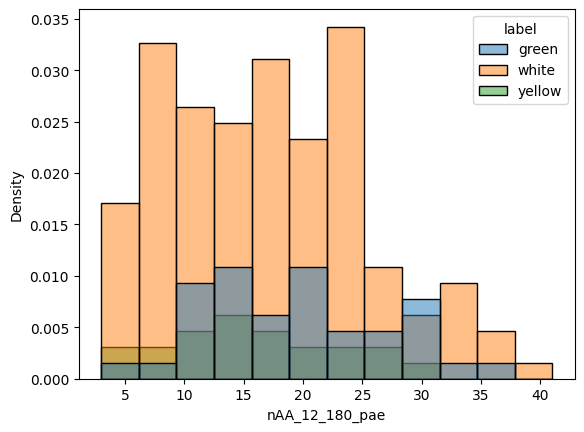

In [60]:
cols_to_visualize = ["nAA_6_180_pae", "nAA_12_180_pae", "nAA_18_180_pae", "nAA_24_180_pae", "nAA_24_180_pae_smooth10", "nAA_6_180_pae_smooth10", "nAA_12_180_pae_smooth10", "nAA_18_180_pae_smooth10", "IDR"]

sns.histplot(data=peptides_with_alphafold, x=cols_to_visualize[1], hue="label", stat="density")

In [61]:
peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_3496/1280371745.py:1: FutureWarning: The provided callable <function mean at 0x1083dd4c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.mean)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
label,,,,,,,,,
green,2.461538,19.461538,55.769231,103.846154,97.417582,2.403541,18.932234,51.292430,0.025641
white,2.349650,17.013986,45.608392,87.832168,84.187780,2.283280,16.479866,44.194430,0.181818
yellow,2.238095,16.142857,43.238095,79.761905,79.859410,2.350718,17.051398,43.321618,0.190476


In [62]:
peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.median)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_3496/4091559531.py:1: FutureWarning: The provided callable <function median at 0x108775ee0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.median)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
label,,,,,,,,,
green,2.0,19.0,53.0,104.0,96.238095,2.285714,18.523810,50.142857,0.0
white,2.0,16.0,47.0,85.0,92.380952,2.238095,16.571429,47.714286,0.0
yellow,2.0,15.0,46.0,80.0,76.952381,2.285714,16.095238,40.238095,0.0


In [63]:
peptides_with_alphafold["structure_group"]

0              STRN
1              HELX
2              HELX
3              BEND
4              TURN
           ...     
198            STRN
199            HELX
200            HELX
201    unstructured
202            HELX
Name: structure_group, Length: 203, dtype: object

In [64]:
peptides_with_alphafold.groupby(["label", "structure_group"]).agg("count").rename({"Peptide Sequence": "Count"}, axis=1)[["Count"]]

Count
label  structure_group       
green  BEND                 5
       HELX                23
       STRN                 7
       TURN                 3
       unstructured         1
white  BEND                12
       HELX                87
       STRN                16
       TURN                11
       unstructured        17
yellow BEND                 3
       HELX                11
       STRN                 3
       TURN                 3
       unstructured         1

In [66]:
# analysis for radius = 18

# Filter the dataset for what we want to compare:
green = peptides_with_alphafold[peptides_with_alphafold['label'] == 'green']
white = peptides_with_alphafold[peptides_with_alphafold['label'] == 'white']

green = green['nAA_18_180_pae']
white = white['nAA_18_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(green, white)

TtestResult(statistic=2.2546986381141707, pvalue=0.02535716483878465, df=180.0)

In [67]:
# analysis for radius = 18

# Filter the dataset for what we want to compare:
green = peptides_with_alphafold[peptides_with_alphafold['label'] == 'green']
yellow = peptides_with_alphafold[peptides_with_alphafold['label'] == 'yellow']

green = green['nAA_18_180_pae']
yellow = yellow['nAA_18_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(green, yellow)

TtestResult(statistic=1.7581088545452634, pvalue=0.08400483277415433, df=58.0)

In [68]:
temp_pwa = peptides_with_alphafold.copy()
temp_pwa["is_enriched"] = temp_pwa["label"].apply(lambda label: 1 if label == "yellow" or label == "green" else 0)

temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_3496/1697412143.py:4: FutureWarning: The provided callable <function mean at 0x1083dd4c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.mean)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
is_enriched,,,,,,,,,
0,2.349650,17.013986,45.608392,87.832168,84.187780,2.283280,16.479866,44.194430,0.181818
1,2.383333,18.300000,51.383333,95.416667,91.272222,2.385053,18.273942,48.502646,0.083333


In [ ]:
# analysis for radius = 10

# Filter the dataset for what we want to compare:
enriched = temp_pwa[temp_pwa['is_enriched'] == 1]
not_enriched = temp_pwa[temp_pwa['is_enriched'] == 0]

enriched = enriched['nAA_24_180_pae']
not_enriched = not_enriched['nAA_24_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(enriched, not_enriched)

In [ ]:
cols_to_visualize = ["nAA_5_180_pae", "nAA_10_180_pae", "nAA_15_180_pae", "nAA_24_180_pae", "nAA_12_70_pae", "nAA_24_180_pae_smooth10", "IDR"]

sns.histplot(data=temp_pwa, x=cols_to_visualize[1], hue="is_enriched", stat="density")

In [ ]:
temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.var)

In [ ]:
temp_pwa["Protein ID"]